In [99]:
import time
import os
import argparse
import json
import cv2
import sys
sys.path += [os.path.abspath('keras-yolo3-master')]

from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from tensorflow.keras.models import load_model
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from panel_disconnect import disconnect




# Define Image Path and output

In [100]:
input_path   = '100_Example/'
output_path  = 'Result_Complete_Example/'
makedirs(output_path)

# Load Model (Panel Detector, Soiling and Diode)

In [101]:
## Config of trained model, change this for use different trained model
config_path_panel  = 'config_full_yolo_panel_infer.json' #Panel
config_path_soiling  = 'config_full_yolo_fault_1_infer.json' #Soiling
config_path_diode  = 'config_full_yolo_fault_4_infer.json'  #Diode




## Parameters of detection
net_h, net_w = 416, 416 # a multiple of 32, the smaller the faster
obj_thresh, nms_thresh, nms_thresh_panel = 0.5, 0.45, 0.3

####################################################
#####   Load the model Panel Detector  #############
####################################################
with open(config_path_panel) as config_buffer:
        config_panel = json.load(config_buffer)

os.environ['CUDA_VISIBLE_DEVICES'] = config_panel['train']['gpus']
infer_model_panel = load_model(config_panel['train']['saved_weights_name'])

####################################################
#####   Load the model Soiling  #############
####################################################
with open(config_path_soiling) as config_buffer:
        config_soiling = json.load(config_buffer)

infer_model_soiling = load_model(config_soiling['train']['saved_weights_name'])

####################################################
#####   Load the model Soiling  #############
####################################################
with open(config_path_diode) as config_buffer:
        config_diode = json.load(config_buffer)

infer_model_diode = load_model(config_diode['train']['saved_weights_name'])

In [102]:
# Load Image paths

In [103]:
image_paths = []

if os.path.isdir(input_path):
    for inp_file in os.listdir(input_path):
        image_paths += [input_path + inp_file]
else:
    image_paths += [input_path]

image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg', '.png', 'JPEG'])]

# the main loop
times = []


In [104]:
# Detection of images

In [105]:
for image_path in image_paths:
    image = cv2.imread(image_path)
    print(image_path)
    start = time.time()
    # predict the bounding boxes
    boxes_soiling = get_yolo_boxes(infer_model_soiling, [image], net_h, net_w, config_soiling['model']['anchors'], obj_thresh, nms_thresh)[0]
    boxes_diode = get_yolo_boxes(infer_model_diode, [image], net_h, net_w, config_diode['model']['anchors'], obj_thresh, nms_thresh)[0]
    boxes_panel = get_yolo_boxes(infer_model_panel, [image], net_h, net_w, config_panel['model']['anchors'], obj_thresh, nms_thresh_panel)[0]
    boxes_panel = [box for box in boxes_panel if box.get_score() > obj_thresh]
    boxes_disc = disconnect(image, boxes_panel, z_thresh = 1.8)
    print('Elapsed time = {}'.format(time.time() - start))
    times.append(time.time() - start)
    # Draw boxes
    draw_boxes(image, boxes_soiling, config_soiling['model']['labels'], obj_thresh, number_color = 0)
    draw_boxes(image, boxes_diode, config_diode['model']['labels'], obj_thresh, number_color = 2)
    draw_boxes(image, boxes_disc, ['disc'], obj_thresh, number_color = 5)
    
    # write the image with bounding boxes to file
    cv2.imwrite(output_path + image_path.split('/')[-1], np.uint8(image))

file = open(output_path + 'time.txt','w')
file.write('Tiempo promedio:' + str(np.mean(times)))
file.close()

100_Example/Mision 4_DJI_0067.jpg
Elapsed time = 10.420740842819214
100_Example/Mision 9_DJI_0068.jpg
Elapsed time = 6.116612672805786
100_Example/Mision 9_DJI_0090.jpg
Elapsed time = 4.469286203384399
100_Example/Mision 10_DJI_0145.jpg
Elapsed time = 4.556819200515747
100_Example/Mision 1_DJI_0019.jpg
Elapsed time = 4.21189284324646
100_Example/Mision 11_DJI_0061.jpg
Elapsed time = 5.409024953842163
100_Example/Mision 9_DJI_0076.jpg
Elapsed time = 5.0739829540252686
100_Example/Mision 4_DJI_0040.jpg
Elapsed time = 5.267049551010132
100_Example/Mision 10_DJI_0103.jpg
Elapsed time = 6.735626935958862
100_Example/Mision 4_DJI_0058.jpg
Elapsed time = 7.793303966522217
100_Example/Mision 9_DJI_0012.jpg
Elapsed time = 5.172106742858887
100_Example/Mision 10_DJI_0010.jpg
Elapsed time = 7.428837776184082
100_Example/Mision 1_DJI_0005.jpg
Elapsed time = 7.278154134750366
100_Example/Mision 4_DJI_0061.jpg
Elapsed time = 7.3159050941467285
100_Example/Mision 6_DJI_0008.jpg
Elapsed time = 6.11170

NameError: name 'args' is not defined

In [ ]:
# Example One image

100_Example/Mision 9_DJI_0064.jpg
Elapsed time = 4.597041130065918


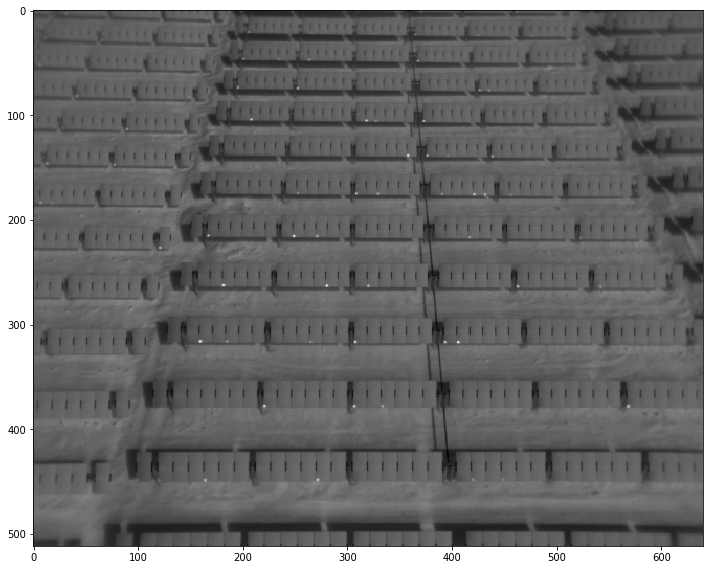

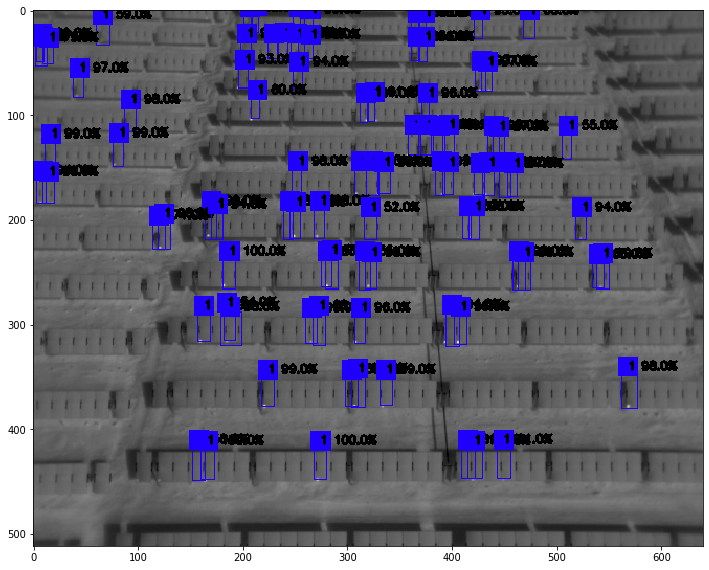

In [106]:
image_path = image_paths[70]

image = cv2.imread(image_path)
plt.figure(figsize=(12, 10))
plt.imshow(image)
print(image_path)

start = time.time()
# predict the bounding boxes
boxes_soiling = get_yolo_boxes(infer_model_soiling, [image], net_h, net_w, config_soiling['model']['anchors'], obj_thresh, nms_thresh)[0]
boxes_diode = get_yolo_boxes(infer_model_diode, [image], net_h, net_w, config_diode['model']['anchors'], obj_thresh, nms_thresh)[0]
boxes_panel = get_yolo_boxes(infer_model_panel, [image], net_h, net_w, config_panel['model']['anchors'], obj_thresh, nms_thresh_panel)[0]
boxes_panel = [box for box in boxes_panel if box.get_score() > obj_thresh]
boxes_disc = disconnect(image, boxes_panel, z_thresh = 1.8)
# Draw boxes
draw_boxes(image, boxes_soiling, config_soiling['model']['labels'], obj_thresh, number_color = 0)
draw_boxes(image, boxes_diode, config_diode['model']['labels'], obj_thresh, number_color = 2)
draw_boxes(image, boxes_disc, ['disc'], obj_thresh, number_color = 5)
print('Elapsed time = {}'.format(time.time() - start))
times.append(time.time() - start)
plt.figure(figsize=(12, 10))
plt.imshow(image)
